##### Import Libraries

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

##### Import Futures Data

In [31]:
df_2024 = pd.read_parquet('Futures_2024.parquet', engine='pyarrow')
df_2023 = pd.read_parquet('Futures_2023.parquet', engine='pyarrow')

##### Pre-Processing of futures data

In [32]:
df = pd.concat([df_2023, df_2024])
df = df[[col for col in df.columns if 'Close' in col]]
df.index = pd.to_datetime(df.index)
filter1 = df.dropna(axis=1, thresh=138428)
filter2 = filter1.loc[:, (df != 0).all(axis=0)]
base_df = filter2.resample('D',origin='2023-01-02 09:30:00').first().dropna()

##### Import Nifty Data, resample, pre-process

In [33]:
df_nifty=pd.read_parquet('Idx_fut.parquet', engine='pyarrow')
df_nifty = df_nifty[[col for col in df_nifty if 'NIFTY_Close' in col]]
df_nifty.index = pd.to_datetime(df_nifty.index)
df_nifty = df_nifty[df_nifty.index > '2023-01-02 09:30:00']
nifty_frame = df_nifty.resample('D',origin='2023-01-02 09:30:00').first().dropna()
nifty_frame.drop(columns = 'BANKNIFTY_Close', inplace=True)
nifty_frame = nifty_frame[nifty_frame.index <'2024-07-02 15:15:00']

##### Get Relative Prices

In [34]:
rel_prices = base_df.div(nifty_frame['NIFTY_Close'], axis=0)

##### Only trade stocks in current nifty index

In [35]:
nifty_50 = ["MARUTI_Close", "ITC_Close", "M&M_Close", "TITAN_Close", "EICHERMOT_Close", "HEROMOTOCO_Close", "SBIN_Close", "HINDUNILVR_Close", "TATAMOTORS_Close", "LT_Close", "ICICIBANK_Close", "BAJAJFINSV_Close", "HDFCLIFE_Close", "SBILIFE_Close", "JSWSTEEL_Close", "HINDALCO_Close", "ASIANPAINT_Close", "ADANIPORTS_Close", "HDFCBANK_Close", "COALINDIA_Close", "TCS_Close", "INFY_Close", "NTPC_Close", "AXISBANK_Close", "APOLLOHOSP_Close", "TATASTEEL_Close", "BHARTIARTL_Close", "ADANIENT_Close", "INDUSINDBK_Close", "TECHM_Close", "KOTAKBANK_Close", "BAJFINANCE_Close", "BPCL_Close", "SHRIRAMFIN_Close", "RELIANCE_Close", "ONGC_Close"]
stock_prices = base_df[nifty_50]
relative_prices = rel_prices[nifty_50]
full_price_data = filter2[nifty_50]

In [36]:
adjusted_index = full_price_data.index - pd.Timedelta(seconds=59)
full_price_data.index = adjusted_index

##### Import lot size data and pre-process

In [37]:
multiplier = pd.read_csv('instrument_list.csv')
multiplier = multiplier.drop(columns=[col for col in multiplier.columns if col not in ['name', 'segment', 'lot_size']])
multiplier_nfo = multiplier[multiplier['segment'] == 'NFO-FUT']
filtered_df = multiplier_nfo.drop_duplicates(subset='name', keep='first')
valid_stocks = filtered_df['name'].unique()
valid_stock_columns = [f"{stock}_Close" for stock in valid_stocks]
columns_to_keep = [col for col in valid_stock_columns if col in stock_prices.columns]
filtered_price_df = stock_prices[columns_to_keep]
filtered_stock_names = [col.split('_')[0] for col in filtered_price_df.columns]
filtered_multiplier_df = filtered_df[filtered_df['name'].isin(filtered_stock_names)]
filtered_multiplier_df.drop(columns = 'segment', inplace=True)
filtered_multiplier_df.set_index('name', inplace=True)
filtered_multiplier_df.columns = ['mult']
mult_list = filtered_multiplier_df
mult_list.index = mult_list.index + '_Close'

C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_16808\984550555.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_multiplier_df.drop(columns = 'segment', inplace=True)


##### Strategy:
- Every day, rank all 36 stocks based on the last (lookback_periods) relative momentum
- Go long with the top (num_stocks) stocks and short with bottom (num_stocks) stocks
- Max 20 stocks in our portfolio
- 1Cr exposure per stock
- Update positions as stocks fall out of and move into the high and low momentum ranks

In [38]:
class PortfolioMomentumStrategy:
    def __init__(self, stock_prices, relative_prices, full_price_data, mult, lookback_period, num_stocks, max_positions, initial_capital=200000000):
        self.stock_prices = stock_prices
        self.relative_prices = relative_prices
        self.full_price_data = full_price_data
        self.mult = mult
        self.max_positions = max_positions
        self.lookback_period = lookback_period
        self.num_stocks = int(min(max_positions // 2, num_stocks))
        self.available_capital = initial_capital
        self.current_positions = {stock: 0 for stock in stock_prices.columns}
        self.pnl_series = pd.Series(index = stock_prices.index)
        self.trade_log = []
        self.exit_log = []
        self.transaction_costs_rate = 0.0011
        self.position_exposure_matrix = pd.DataFrame(index=stock_prices.index, columns=stock_prices.columns)
        #self.position_df = pd.DataFrame(index = full_price_data, columns = stock_prices.columns)
        

    def calculate_momentum(self, data, current_time):
        lookback_time = current_time - pd.Timedelta(days=self.lookback_period)
        if lookback_time in data.index:
            return (data.loc[current_time]/ data.loc[lookback_time] - 1)  # Returns the momentum between now and that time
        else:
            return pd.Series(np.nan, index=data.columns) #In cases of large lookback period
    
    def rank_stocks(self, current_time):
        momentum_scores = self.calculate_momentum(self.relative_prices, current_time)
        ranked_stocks = momentum_scores.sort_values(ascending = False) #Ranks stocks top to bottom of momentum in the time period
        return ranked_stocks
    
    def allocate_positions(self, ranked_stocks, current_prices):
        top_stocks = ranked_stocks.head(self.num_stocks)
        bottom_stocks = ranked_stocks.tail(self.num_stocks)


        long_value = self.available_capital / 2
        short_value = self.available_capital / 2 #Assign half capital to long, half to short

        max_exp_per_stock = 10000000

        long_positions = {}  #To track which stocks we go long and short on and the position size
        short_positions = {}

        #So we don't repeatedly buy/sell if a stock remains in the top/bottom n stocks
        top_stocks = [stock for stock in top_stocks.index if self.current_positions[stock] == 0]
        bottom_stocks = [stock for stock in bottom_stocks.index if self.current_positions[stock] == 0]

        #Tracks total positions, i.e number of stocks in our portfolio
        total_positions = sum(1 for pos in self.current_positions.values() if pos != 0)

        #Go long with the top n
        for stock in top_stocks:
            if total_positions < self.max_positions:  #Only if we don't go over max_positions stocks
                
                #Position size will be the minimum of the exposure per stock/ (total price of contract) and available capital / (total price of contract)
                
                position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), long_value / (current_prices[stock] * self.mult.loc[stock].values)))
                position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values
                
                #Only carry out trade if we have enough capital
                
                if position_cost <= long_value:
                    long_positions[stock] = position_size
                    long_value -= position_cost
                    self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'long', 'size': position_size, 'cost': position_cost[0], 'trading price' : current_prices[stock], 'trade_type' : 'entry', 'multiplier': self.mult.loc[stock].values[0]})
                    total_positions += 1

        #Same process, but for short.
        for stock in bottom_stocks:
            if total_positions < self.max_positions:
                position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), short_value / (current_prices[stock] * self.mult.loc[stock].values)))
                position_cost = position_size * current_prices[stock] * self.mult.loc[stock].values
                if position_cost <= short_value:
                    short_positions[stock] = position_size
                    short_value -= position_cost
                    self.trade_log.append({'date': current_prices.name, 'stock': stock, 'position': 'short', 'size': position_size, 'cost': position_cost[0], 'trading price': current_prices[stock], 'trade_type' : 'entry', 'multiplier': self.mult.loc[stock].values[0]})
                    total_positions += 1

        return long_positions, short_positions  


    def update_positions(self, long_positions, short_positions, previous_prices, current_prices):

        liquidated_pnl = 0
        total_positions = sum(1 for pos in self.current_positions.values() if pos != 0)

        #If stocks move out of the top and bottom n, the position is closed and we calculate the pnl of the close

        for stock in self.current_positions:
            if stock not in long_positions and stock not in short_positions:
                if self.current_positions[stock] != 0:
                    liquidated_pnl = self.current_positions[stock] * (current_prices[stock]) * self.mult.loc[stock].values
                    total_positions -= 1
                    self.exit_log.append({'date': current_prices.name, 'stock': stock, 'position': ' Closing long' if self.current_positions[stock] > 0 else ' Closing short',
                                        'size': abs(self.current_positions[stock]),
                                        'cost': abs(self.current_positions[stock]) * previous_prices[stock] * self.mult.loc[stock].values[0],
                                        'trading price': current_prices[stock],
                                        'trade_type': 'exit', 'multiplier': self.mult.loc[stock].values[0]})
                    self.current_positions[stock] = 0

        #Current_positions tracks the stocks in our portfolio and the position size
        
        for stock, position in long_positions.items():
            self.current_positions[stock] = position

        for stock, position in short_positions.items():
            self.current_positions[stock] = -position

        return liquidated_pnl
    
    def update_position_exposure_matrix(self, current_time):
        current_prices = self.stock_prices.loc[current_time]
        for stock, position in self.current_positions.items():
            exposure = position * current_prices[stock] * self.mult.loc[stock].values[0]
            self.position_exposure_matrix.at[current_time, stock] = [position, exposure]
  
    #Simple function to track pnl

    def calculate_pnl(self, long_positions, short_positions, previous_prices, current_prices):
        pnl = 0

        for stock, position in self.current_positions.items():
            price_change = current_prices[stock] - previous_prices[stock]
            pnl += position * price_change * self.mult.loc[stock].values + self.update_positions(long_positions, short_positions, previous_prices, current_prices)
        return pnl
    
    # def calculate_minutely_pnl(self, current_time):
    #     pnl = 0
    #     for stock, position in self.current_positions.items():
    #         price_change = self.full_price_data.loc[current_time] - self.full_price_data.shift(1).loc[current_time]
    #         pnl += position * price_change * self.mult.loc[stock].values
    #     return pnl
    
    
    def calculate_transaction_costs(self, trades):
        total_transaction_costs = 0
        for trade in trades:
            turnover = trade['size'] * trade['trading price']
            total_transaction_costs += turnover * self.transaction_costs_rate
        return total_transaction_costs

    def trade(self):

        #Indexing to be able to select correct prices

        unique_dates=self.stock_prices.index
        unique_dates=unique_dates[self.lookback_period:]
        # start_timestamp = unique_dates[0]

        #unique_minute_dates = self.full_price_data.loc[start_timestamp:].index
        
        next_unique_dates=self.stock_prices.index
        next_unique_dates=next_unique_dates[self.lookback_period-1:]

        #For every day, apply the strategy
        for current_time,prev_time in zip(unique_dates,next_unique_dates):
            previous_prices = self.stock_prices.loc[prev_time]
            current_prices = self.stock_prices.loc[current_time]
            ranked_stocks = self.rank_stocks(current_time)
            long_positions, short_positions = self.allocate_positions(ranked_stocks, current_prices)
            self.update_positions(long_positions, short_positions, previous_prices, current_prices)
            pnl_raw = self.calculate_pnl(long_positions, short_positions, previous_prices, current_prices) 
            liquidated_pnl = self.update_positions(long_positions, short_positions, previous_prices, current_prices)
            pnl = pnl_raw + liquidated_pnl
            self.update_position_exposure_matrix(current_time)

            day_trades = [trade for trade in self.trade_log if trade['date'] == current_time]
            if day_trades:  
                transaction_costs = self.calculate_transaction_costs(day_trades)
                pnl -= transaction_costs
            
            self.pnl_series[current_time] = pnl 

            self.available_capital += pnl

        return pd.Series(self.pnl_series, index=self.stock_prices.index[self.lookback_period:]).cumsum(), self.position_exposure_matrix
    
    


    def calculate_minutely_pnl(self):
        minutely_pnl_series = pd.Series(index=self.full_price_data.index, dtype=float)
        previous_prices = self.full_price_data.shift(1)

        pnl_changes = self.full_price_data.sub(previous_prices).mul(pd.Series(self.current_positions) * self.mult.values.flatten(), axis=1).sum(axis=1)
        minutely_pnl_series.iloc[:] = pnl_changes.values


        minutely_pnl_series = minutely_pnl_series.cumsum()
        return minutely_pnl_series
    



##### Trade strategy with 10 days lookback, top and bottom 5 stocks, max stocks 20

In [39]:
strategy = PortfolioMomentumStrategy(stock_prices, relative_prices, full_price_data, mult_list, 10, 5, 20)
pnl_series, position_matrix = strategy.trade()

C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_16808\1567809574.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), long_value / (current_prices[stock] * self.mult.loc[stock].values)))
C:\Users\Guest_Account\AppData\Local\Temp\ipykernel_16808\1567809574.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position_size = int(min(max_exp_per_stock / (current_prices[stock] * self.mult.loc[stock].values), short_value / (current_prices[stock] * self.mult.loc[stock].values)))


In [40]:
pnl_series

DateTime
2023-01-12 09:30:00    2.382699e+05
2023-01-13 09:30:00    5.753595e+05
2023-01-15 09:30:00    6.660395e+05
2023-01-16 09:30:00    7.794955e+05
2023-01-17 09:30:00    1.024783e+06
                           ...     
2024-06-27 09:30:00    1.667844e+08
2024-06-28 09:30:00    1.663893e+08
2024-06-30 09:30:00    1.663471e+08
2024-07-01 09:30:00    1.663334e+08
2024-07-02 09:30:00    1.661230e+08
Length: 449, dtype: float64

In [41]:
position_matrix.dropna(inplace=True)

In [42]:
position_matrix

,MARUTI_Close,ITC_Close,M&M_Close,TITAN_Close,EICHERMOT_Close,HEROMOTOCO_Close,SBIN_Close,HINDUNILVR_Close,TATAMOTORS_Close,LT_Close,...,BHARTIARTL_Close,ADANIENT_Close,INDUSINDBK_Close,TECHM_Close,KOTAKBANK_Close,BAJFINANCE_Close,BPCL_Close,SHRIRAMFIN_Close,RELIANCE_Close,ONGC_Close
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-01-12 09:30:00,"[0, 0.0]","[0, 0.0]","[21, 9753450.0]","[-23, -9949800.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[43, 9921175.0]","[0, 0.0]",...,"[-27, -9848317.5]","[-9, -9783855.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[-13, -9616343.75]","[15, 9377100.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]"
2023-01-13 09:30:00,"[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]",...,"[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[-25, -9666374.999999998]","[0, 0.0]","[0, 0.0]"
2023-01-15 09:30:00,"[0, 0.0]","[0, 0.0]","[21, 9787995.0]","[-23, -9801076.25]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[43, 9814750.0]","[0, 0.0]",...,"[-27, -9870120.0]","[-8, -8946000.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]"
2023-01-16 09:30:00,"[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[-18, -9938722.5]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]",...,"[0, 0.0]","[0, 0.0]","[16, 9976000.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]"
2023-01-17 09:30:00,"[23, 9693177.5]","[18, 9521280.0]","[21, 9654592.5]","[23, 9690791.25]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]",...,"[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[-13, -9720831.250000002]","[-15, -9448650.0]","[-26, -9890010.000000002]","[-16, -9858400.0]","[-35, -9971500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-27 09:30:00,"[0, 0.0]","[0, 0.0]","[-10, -9864225.0]","[0, 0.0]","[-12, -9873255.000000002]","[-12, -9781740.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]",...,"[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[13, 9380800.0]","[0, 0.0]","[0, 0.0]","[11, 9808260.0]","[0, 0.0]","[0, 0.0]"
2024-06-28 09:30:00,"[0, 0.0]","[0, 0.0]","[0, 0.0]","[-16, -9534700.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]",...,"[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[-18, -9890100.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]"
2024-06-30 09:30:00,"[0, 0.0]","[0, 0.0]","[-9, -9021285.0]","[0, 0.0]","[-12, -9903390.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]",...,"[14, 9755882.5]","[0, 0.0]","[-13, -9548500.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[0, 0.0]","[11, 9669000.0]","[12, 9432000.0]","[0, 0.0]"


##### Our cumulative pnl

In [43]:
initial_cap = 200000000

In [44]:
cagr = 100*((366000000/200000000)**(1/1.5) - 1)

In [45]:
minutely_pnl_series = strategy.calculate_minutely_pnl()

In [46]:
minutely_pnl_series

DateTime
2023-01-02 09:15:00           0.00
2023-01-02 09:16:00      350995.00
2023-01-02 09:17:00      418861.25
2023-01-02 09:18:00      536848.75
2023-01-02 09:19:00      538427.50
                          ...     
2024-07-02 15:26:00    25576007.50
2024-07-02 15:27:00    25507832.50
2024-07-02 15:28:00    25492037.50
2024-07-02 15:29:00    25517806.25
2024-07-02 15:30:00    25512641.25
Length: 138429, dtype: float64

In [47]:
relative_series = pnl_series/initial_cap
relative_series

DateTime
2023-01-12 09:30:00    0.001191
2023-01-13 09:30:00    0.002877
2023-01-15 09:30:00    0.003330
2023-01-16 09:30:00    0.003897
2023-01-17 09:30:00    0.005124
                         ...   
2024-06-27 09:30:00    0.833922
2024-06-28 09:30:00    0.831947
2024-06-30 09:30:00    0.831735
2024-07-01 09:30:00    0.831667
2024-07-02 09:30:00    0.830615
Length: 449, dtype: float64

##### Plot the cumulative pnl

In [48]:
def plot_pnl(pnl_series):
    plt.figure(figsize=(10, 6))
    pnl_series.plot()
    plt.title('Cumulative PnL')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.grid(True)
    plt.show()

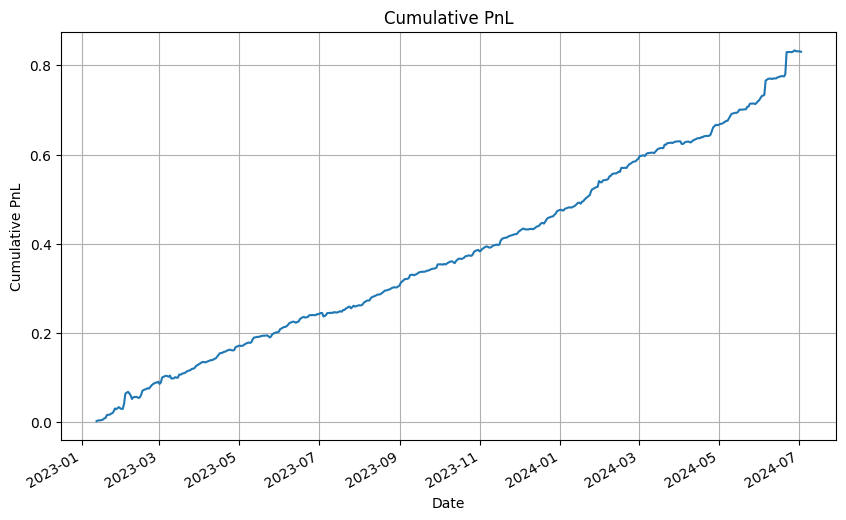

In [49]:
plot_pnl(relative_series)

##### Dataframe of trade log

In [50]:
trade_log_df = pd.DataFrame(strategy.trade_log)


In [51]:
exit_log_df = pd.DataFrame(strategy.exit_log)


In [52]:
full_trade_log = pd.concat([trade_log_df, exit_log_df], ignore_index=True)

full_trade_log.sort_values(by=['date', 'trade_type'], ascending=[True, False], inplace=True)


full_trade_log.reset_index(drop=True, inplace=True)

In [53]:
full_trade_log

,date,stock,position,size,cost,trading price,trade_type,multiplier
0,2023-01-12 09:30:00,HDFCLIFE_Close,long,15,9966825.0,604.05,entry,1100
1,2023-01-12 09:30:00,TATAMOTORS_Close,long,43,9921175.0,419.50,entry,550
2,2023-01-12 09:30:00,M&M_Close,long,21,9753450.0,1327.00,entry,350
3,2023-01-12 09:30:00,SBILIFE_Close,long,20,9779250.0,1303.90,entry,375
4,2023-01-12 09:30:00,BPCL_Close,long,15,9377100.0,347.30,entry,1800
...,...,...,...,...,...,...,...,...
5869,2024-07-02 09:30:00,BAJFINANCE_Close,short,11,9948125.0,7235.00,entry,125
5870,2024-07-02 09:30:00,BPCL_Close,short,18,9906300.0,305.75,entry,1800
5871,2024-07-02 09:30:00,SHRIRAMFIN_Close,short,11,9582870.0,2903.90,entry,300
5872,2024-07-02 09:30:00,RELIANCE_Close,short,12,9387300.0,3129.10,entry,250


In [54]:
full_trade_log.to_csv('script_1_tl.csv')

##### Analyse metrics of portfolio

In [55]:
initial_cap = 200000000
pct = 100
daily_ret = pct* (pnl_series.diff() / initial_cap)

In [59]:
#daily_ret.plot(kind = 'hist', bins = 50)

In [57]:
annual_mean_returns = daily_ret.mean()*252
annial_mean_std = daily_ret.std()*np.sqrt(252)
s_r = annual_mean_returns/ annial_mean_std

In [58]:
print('Annual Mean Return:', annual_mean_returns,
       'Annual_Risk:', annial_mean_std,
        'Sharpe:', s_r)

Annual Mean Return: 46.655081153469844 Annual_Risk: 6.0914639734187075 Sharpe: 7.659091698983758
